## Imports

In [52]:
# LIBRARIES
from argparse import ArgumentParser
import os
import sys
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.metrics import Accuracy

# Pytorch modules
import torch
import torch.nn
import torchvision.models as models
from torch.nn import functional as F
from torch import nn
from torch.optim import Adam
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import transforms


# Pytorch-Lightning
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
import pytorch_lightning as pl
import torchmetrics
from torchmetrics import Accuracy
from vit_pytorch import ViT
from transformers import ViTConfig


# Extras
from argparse import Namespace
from torchsummary import summary

# Image
import PIL
from PIL import Image

# Visualization
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

# Einops and Numpy
from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange
import numpy as np

# Plots
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

# Transforms
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# Attention-weight wrapper
from vit_pytorch.vit import ViT
from vit_pytorch.recorder import Recorder

# probing ViTs
import zipfile
from io import BytesIO

import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras



root_dir = '/home/lpandey/'
sys.path.append(root_dir)
from models.vit_contrastive import LitClassifier

## Set Model Parameters

In [53]:
RESOLUTION = 64 # image resolution on which the model was trained
PATCH_SIZE = 8 # patch size used while training the model

## Load Model

In [54]:
# load checkpoint
ckpt = '/data/lpandey/LOGS/VIT_Time/RetinalWaves_Project/64X64_80k/ViT_3H/V1O1/version_0/checkpoints/epoch=99-step=14699.ckpt'
# initialize model
model = LitClassifier.load_from_checkpoint(ckpt)
# freeze network
for params in model.parameters():
    params.requires_grad=False
model.eval()

LitClassifier(
  (backbone): Backbone(
    (model): VisionTransformer(
      (model): ViT(
        (to_patch_embedding): Sequential(
          (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
          (1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (2): Linear(in_features=192, out_features=768, bias=True)
          (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (transformer): Transformer(
          (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (layers): ModuleList(
            (0): ModuleList(
              (0): Attention(
                (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                (attend): Softmax(dim=-1)
                (dropout): Dropout(p=0.0, inplace=False)
                (to_qkv): Linear(in_features=768, out_features=576, bias=False)
                (to_out): Sequential(
                  (0): Linear

## Load Test Image

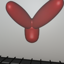

In [71]:
image_path = '/home/lpandey/data/paper1/Task8TestDataset_NoAug_11k_RGB/V1O1/output_20.png'
img = Image.open(image_path)
img

## Image Transforms

In [72]:
# Define transforms for test
IMG_SIZE = (64, 64)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [73]:
img_tensor = transforms(img).unsqueeze(0)
img_tensor.shape # [batch, channels, H, W]

torch.Size([1, 3, 64, 64])

## Extract Attention Weights

We use an open-source wrapper to extract the weights from all the attention-heads in a single tensor.
Finally, we slice the tensor to get individual attention weights.

In [74]:
# wrapper class
v = Recorder(model.backbone.model.model)
# the model is now wrapped inside Recorder
v

Recorder(
  (vit): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
      (1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=192, out_features=768, bias=True)
      (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0): ModuleList(
          (0): Attention(
            (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=768, out_features=576, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=192, out_features=768, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
          (1): Fe

## Pass Test Image to the Model

In [75]:
preds, att_wt = v(img_tensor)
# preds.shape - [1,512]
# att_wt - tensor containing the attention weights for all the attention heads in the model

In [76]:
print("shape of attention weight tensor: ", att_wt.shape) # (batch, layers, heads, patch+pos_emb, patch+pos_emb)
print("shape of preds: ", preds.shape)

shape of attention weight tensor:  torch.Size([1, 3, 3, 65, 65])
shape of preds:  torch.Size([1, 512])


## Extract Individual Attention Weight 

In [85]:
# Example for a 3 heads network!

# FOR 3 ATTENTION HEADS
w0 = att_wt[:,:,0,:,:] # head1
w1 = att_wt[:,:,1,:,:] # head2
w2 = att_wt[:,:,2,:,:] # head3

w0.shape

torch.Size([1, 3, 65, 65])

In [86]:
w_dict = {
    'transformer_block_0_att':w0.detach().numpy(),
    'transformer_block_1_att':w1.detach().numpy(),
    'transformer_block_2_att':w2.detach().numpy()
}

## Helper Functions

In [87]:
crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)


def preprocess_image(image, model_type, size=RESOLUTION):
    # Turn the image into a numpy array and add batch dim.
    image = np.array(image)
    image = tf.expand_dims(image, 0)

    # If model type is vit rescale the image to [-1, 1].
    if model_type == "original_vit":
        image = rescale_layer(image)

    # Resize the image using bicubic interpolation.
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")

    # Crop the image.
    image = crop_layer(image)

    # If model type is DeiT or DINO normalize the image.
    if model_type != "original_vit":
        image = norm_layer(image)

    return image.numpy()


def load_image_from_url(url, model_type):
    # Credit: Willi Gierke
    #response = requests.get(url)
    image = Image.open(url)
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image


Num Heads: 3.


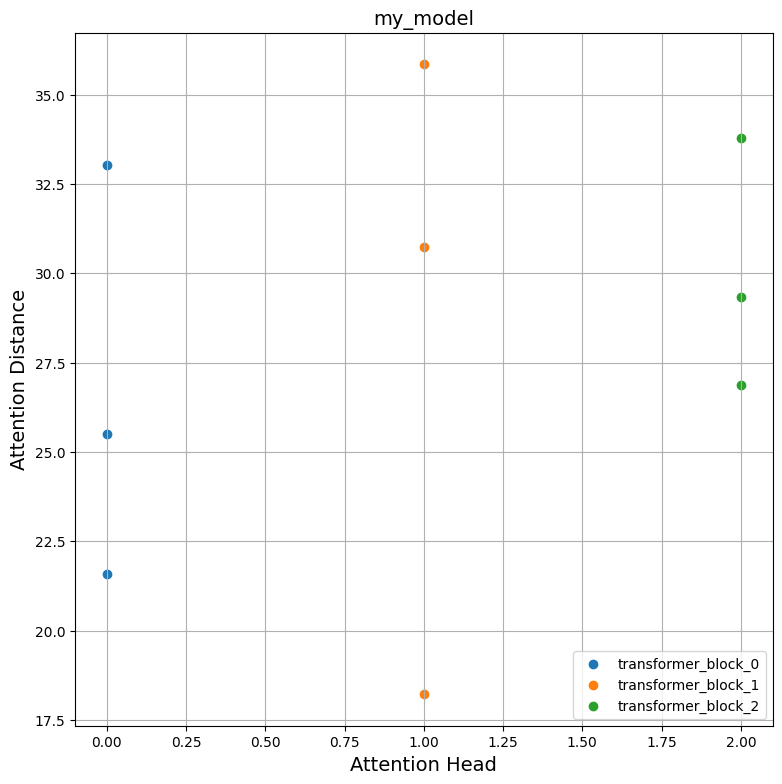

In [88]:
# Build the mean distances for every Transformer block.
mean_distances = {
    f"{name}_mean_dist": compute_mean_attention_dist(
        patch_size=PATCH_SIZE,
        attention_weights=attention_weight,
        model_type="original_vit",
    )
    for name, attention_weight in w_dict.items()
}

# Get the number of heads from the mean distance output.
num_heads = tf.shape(mean_distances["transformer_block_0_att_mean_dist"])[-1].numpy()

# Print the shapes
print(f"Num Heads: {num_heads}.")

plt.figure(figsize=(9, 9))

for idx in range(len(mean_distances)):
    mean_distance = mean_distances[f"transformer_block_{idx}_att_mean_dist"]
    x = [idx] * num_heads
    y = mean_distance[0, :]
    plt.scatter(x=x, y=y, label=f"transformer_block_{idx}")

plt.legend(loc="lower right")
plt.xlabel("Attention Head", fontsize=14)
plt.ylabel("Attention Distance", fontsize=14)
plt.title("my_model", fontsize=14)
plt.grid()
plt.show()

In [89]:
def compute_distance_matrix(patch_size, num_patches, length):
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:  # zero distance
                continue

            xi, yi = (int(i / length)), (i % length)
            xj, yj = (int(j / length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix


def compute_mean_attention_dist(patch_size, attention_weights, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # The attention_weights shape = (batch, num_heads, num_patches, num_patches)
    attention_weights = attention_weights[
        ..., num_cls_tokens:, num_cls_tokens:
    ]  # Removing the CLS token
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert length**2 == num_patches, "Num patches is not perfect square"

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token.
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(
        mean_distances, axis=-1
    )  # Sum along last axis to get average distance per token
    mean_distances = np.mean(
        mean_distances, axis=-1
    )  # Now average across all the tokens

    return mean_distances


In [90]:
def attention_heatmap(attention_score_dict, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1

    # Sort the Transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)
    
    #print(attention_score_list)

    # Process the attention maps for overlay.
    #print(image.shape) # [1,64,64,3]
    
    w_featmap = image.shape[2] // PATCH_SIZE # 8
    h_featmap = image.shape[1] // PATCH_SIZE # 8

    attention_scores = attention_score_dict[attention_score_list[0]] # gives the attention scores of all heads from the last block
    
    #print(attention_scores.shape) # [1,6,65,65] at this point we still have the cls tokens attached to patches
    
    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)
    '''
    Here, attention_scores is a tensor of shape [1, 6, 65, 65], 
    so attention_scores[0, :, 0, num_tokens:] selects a sub-tensor 
    of shape [6, 65-num_tokens, 65-num_tokens]. The first dimension
    (batch) is fixed at 0 because there is only one example in the
    batch. The second dimension (number of heads) is selected 
    entirely by the : operator, so all heads are included 
    (in the plotting function, heads are indexed). The 
    third dimension (source patches) is fixed at 0, so the attention
    scores are only computed between the first patch and the remaining
    patches. The fourth dimension (target patches) is sliced starting 
    from index num_tokens to the end, so the attention scores are only
    computed between the num_tokens-th patch and the remaining patches.
    '''
    #print("after reshaping - ", attentions.shape) # [6,64] 
    
    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    #print(attentions.shape) # [6,8,8]
    
    attentions = attentions.transpose((1, 2, 0))
    #print(attentions.shape) # [8,8,6]
    
    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(
        attentions, size=(h_featmap * PATCH_SIZE, w_featmap * PATCH_SIZE)
    )
    #print(attentions.shape) # [64,64,6]
    return attentions

## Load Test Image
#### This image will be used as the background for the heatmaps

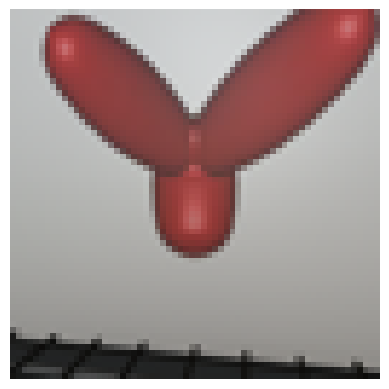

In [91]:
image, preprocessed_image = load_image_from_url(image_path, model_type="original_vit")

plt.imshow(image)
plt.axis("off")
plt.show()

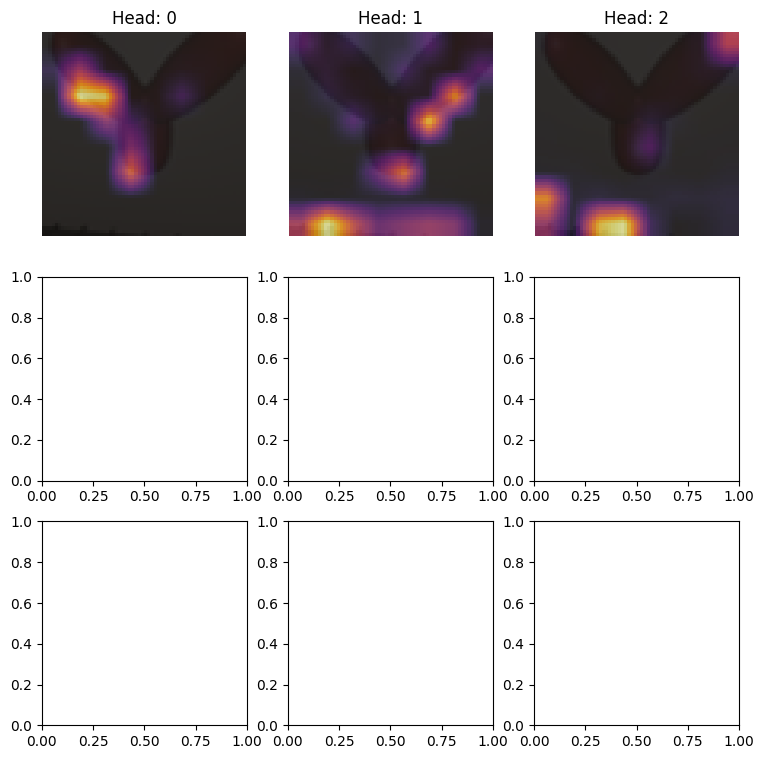

In [94]:
# EXAMPLE FOR 3 ATTENTION HEADS NETWORK

# De-normalize the image for visual clarity.
in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

# Generate the attention heatmaps.
attentions = attention_heatmap(w_dict, preprocessed_img_orig)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
img_count = 0

for i in range(1):
    for j in range(3):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0])
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.7)
            axes[i, j].title.set_text(f"Head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1